In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2

In [65]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [66]:
file_ROI = glob.glob('ROIs/*')
file_ROI

['ROIs\\roi1.bmp', 'ROIs\\roi3.bmp', 'ROIs\\roi4.bmp', 'ROIs\\roi5.bmp']

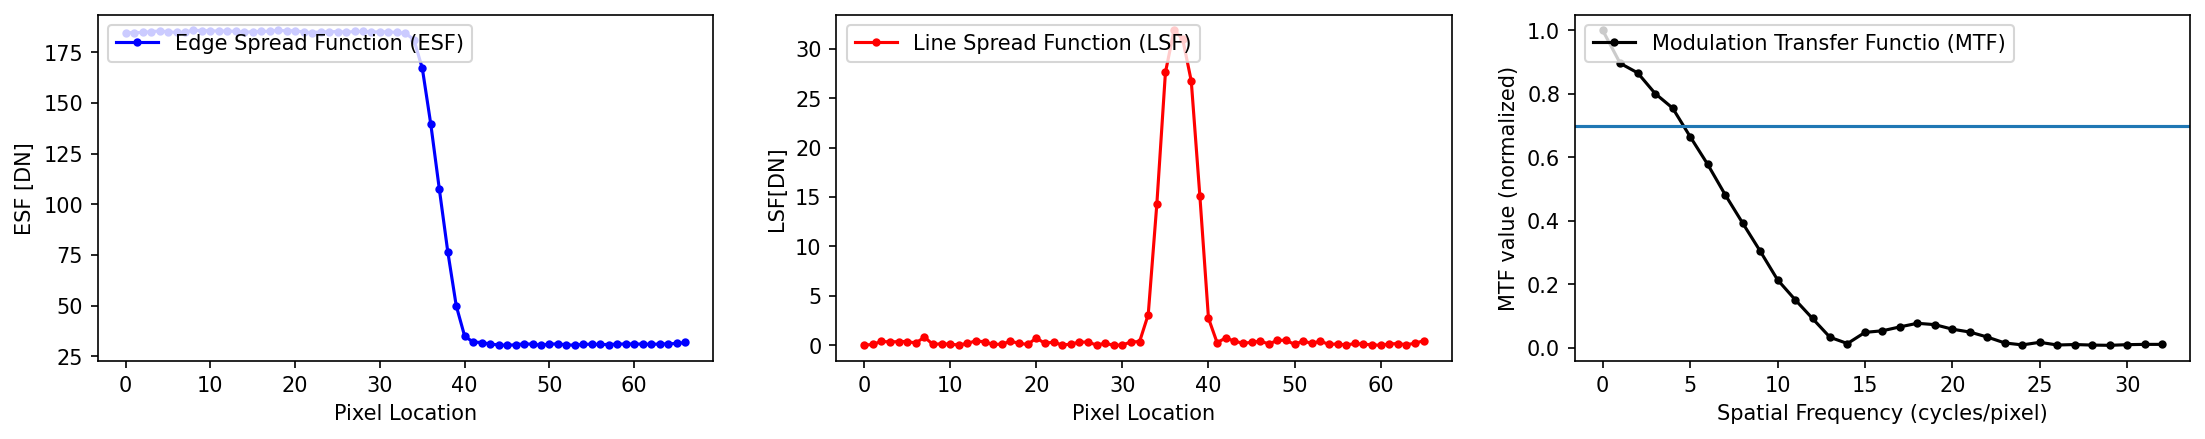

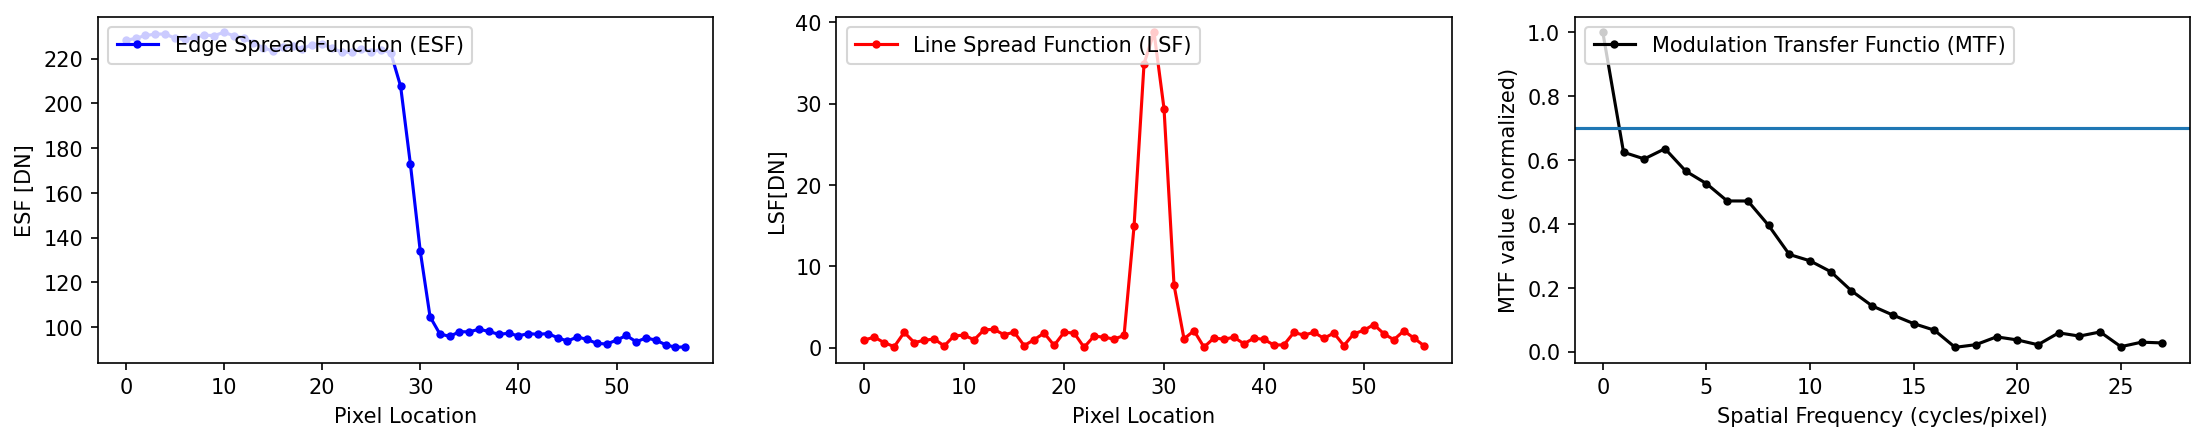

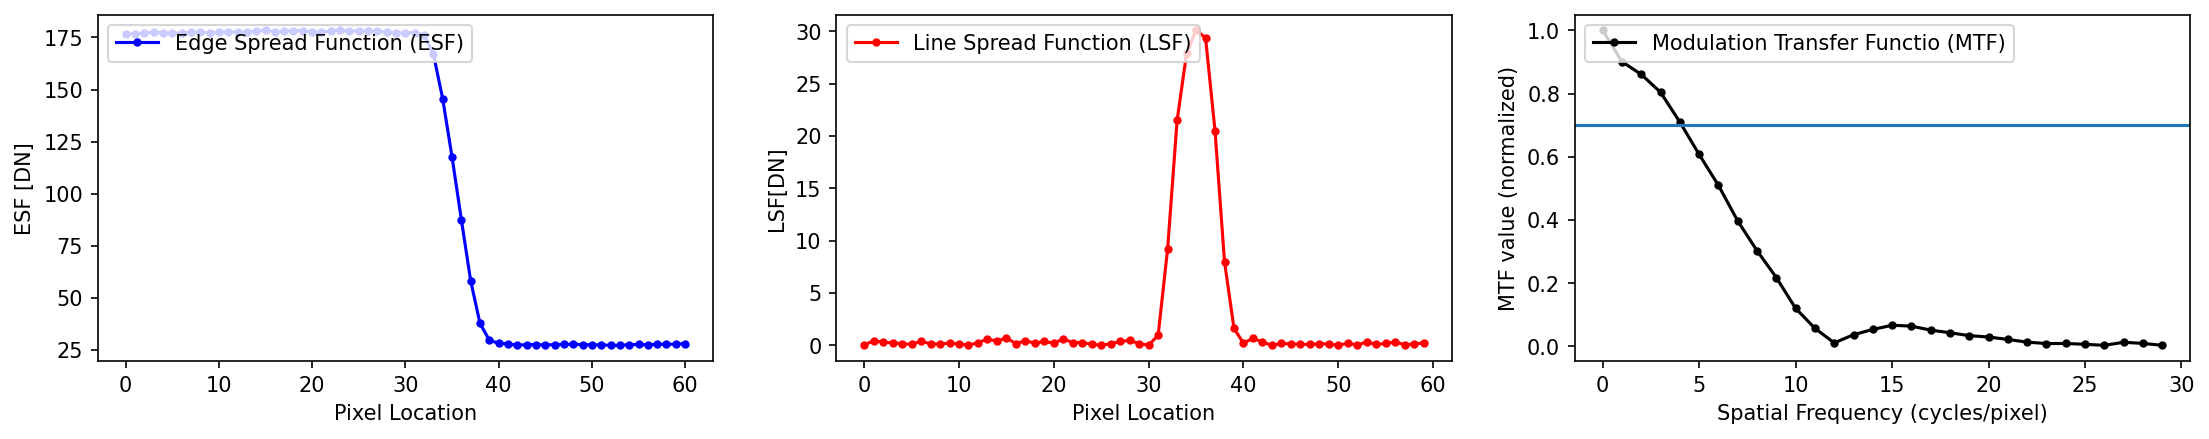

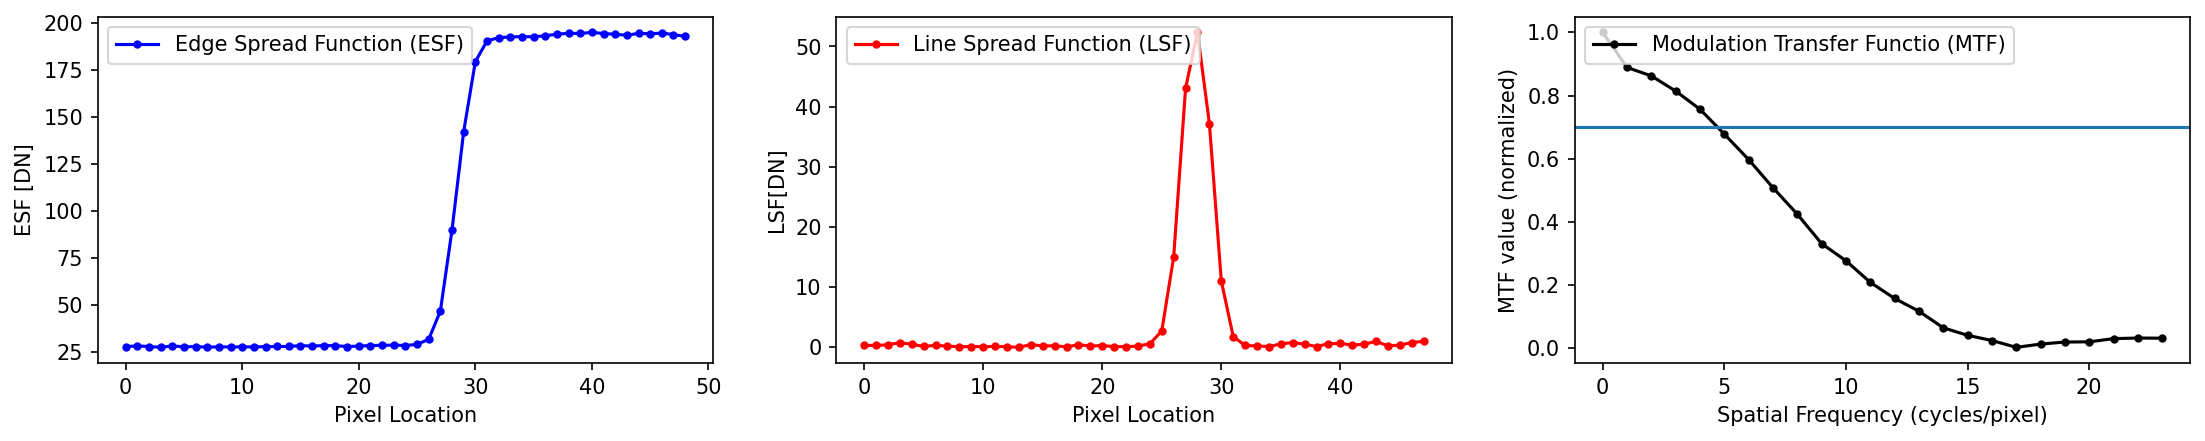

In [67]:
MTF_test_data = []

for file in file_ROI:
    image = plt.imread(file)
    image = rgb2gray(image)

    ROI = image

    ROI_SFR = ROI.mean(axis = 0)
    ROI_LSF = np.abs(np.diff(ROI_SFR))

    ROI_MTF = np.abs(np.fft.fft(ROI_LSF))
    ROI_MTF = ROI_MTF[:]/np.max(ROI_MTF)
    ROI_MTF = ROI_MTF[:len(ROI_MTF)//2]

    x_SFR = np.arange(0, len(ROI_SFR))
    x_LSF = np.arange(0, len(ROI_LSF))

    plt.figure(figsize = (6*3,3), dpi = 150, facecolor=None)
    plt.subplot(131)
    plt.plot(x_SFR, ROI_SFR, 'b.-', label='Edge Spread Function (ESF)')
    plt.xlabel('Pixel Location')
    plt.ylabel('ESF [DN]')
    plt.legend(loc = "upper left")

    plt.subplot(132)
    plt.plot(x_LSF, ROI_LSF, 'r.-', label='Line Spread Function (LSF)')
    plt.xlabel('Pixel Location')
    plt.ylabel('LSF[DN]')
    plt.legend(loc = 'upper left')

    x_MTF= np.arange(0, len(ROI_MTF))

    plt.subplot(133)
    plt.plot(x_MTF, ROI_MTF, 'k.-', label='Modulation Transfer Functio (MTF)')
    plt.axhline(y = 0.7, )
    plt.xlabel('Spatial Frequency (cycles/pixel)')
    plt.ylabel('MTF value (normalized)')
    plt.legend(loc = 'upper left')

    MTF_test_data.append(list(zip(x_MTF, ROI_MTF)))
    
plt.show()


In [68]:
#ROI_coords = cv2.selectROI(image)
#ROI = image[int(ROI_coords[1]):int(ROI_coords[1] + ROI_coords[3]), int(ROI_coords[0]):int(ROI_coords[0] + ROI_coords[2])]

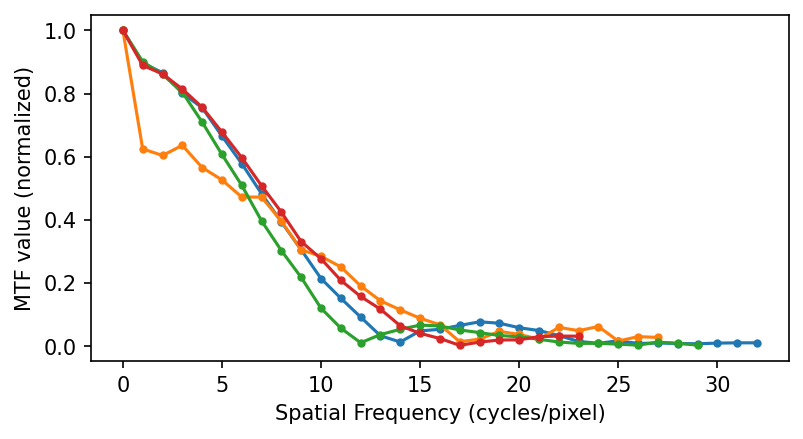

In [71]:
plt.figure(figsize = (6,3), dpi = 150, facecolor=None)
for MTF in MTF_test_data:
    plt.plot([i[0] for i in MTF], [i[1] for i in MTF], '.-')

plt.xlabel('Spatial Frequency (cycles/pixel)')
plt.ylabel('MTF value (normalized)')
#plt.legend(loc = 'upper left')
plt.show()